In [ ]:
# General (scientific) computing
import os
import sys
import time
import glob
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import matplotlib as mpl
from matplotlib.patches import Ellipse
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'Greys_r'

# Astronomical computing
!pip install reproject
!pip install astropy
!pip install sep
from astropy.visualization import simple_norm, AsinhStretch
import sep
import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units as u
from reproject import reproject_interp
from scipy.optimize import curve_fit

!pip install galsim
import galsim

!pip install lmfit
import lmfit
from lmfit import conf_interval2d

!pip install emcee
import emcee
!pip install corner
import corner

from sklearn.utils import resample

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.2/210.2 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 18.2 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=8aef53ee6b8144ccbe527b4f4b5683247a967b63927e909999350b1657d05b5d
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/Shareddrives/Physics100_asteroids/code')

In [ ]:
# Need to load in CALIBRATED files so photometric counts are accurate
outdir = "/content/drive/Shareddrives/Physics100_asteroids/output_files/pallas"
caldatadir_R = os.path.join(outdir + "/2024_05_29", "*")
caldatafilelist = glob.glob(caldatadir_R)

In [ ]:
# Check if calibrated files where properly loaded in
print(len(caldatafilelist))
length = len(caldatafilelist)

98


In [ ]:
calfits_R = fits.open(caldatafilelist[length-1])
calfits_R_header = calfits_R[0].header
calfits_R_data = calfits_R[0].data # I cant remember if this is all the images from the observation or just one?
wcs = WCS(calfits_R[0].header)
ra, dec = wcs.all_pix2world([[x_source, y_source]], 0)[0]

In [ ]:
# Get the header of the primary HDU (assuming date information is in the primary HDU)
header = calfits_R_header

# Check for DATE-OBS keyword first
if 'DATE-OBS' in header:
    observation_date = header['DATE-OBS']
elif 'DATE' in header:
    observation_date = header['DATE']
elif 'MJD-OBS' in header:
    from astropy.time import Time
    observation_date = Time(header['MJD-OBS'], format='mjd').isot
elif 'UTSTART' in header:
    observation_date = header['UTSTART']
else:
    observation_date = None  # Handle the case where date information is not available

# Print or use the observation date
if observation_date:
    print('Observation Date:', observation_date)
else:
    print('Observation Date not found in FITS header.')


Observation Date: 2024-05-30T05:57:33.09


Text(0.5, 1.0, 'Original Image 2024-05-30T05:57:33.09')

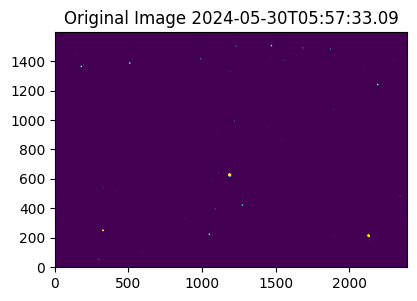

In [ ]:
# Plot the original and trimmed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(calfits_R_data, cmap='viridis', origin='lower', vmin=100, vmax=500)  # Adjust vmin and vmax as needed
plt.title('Original Image ' + observation_date)

The brightest source is the only one in the trimmed image.
Coordinates of the source: x = 1184.1355257398955, y = 625.1201755583278
RA:  244.55638857662967
DEC:  26.716520204067002


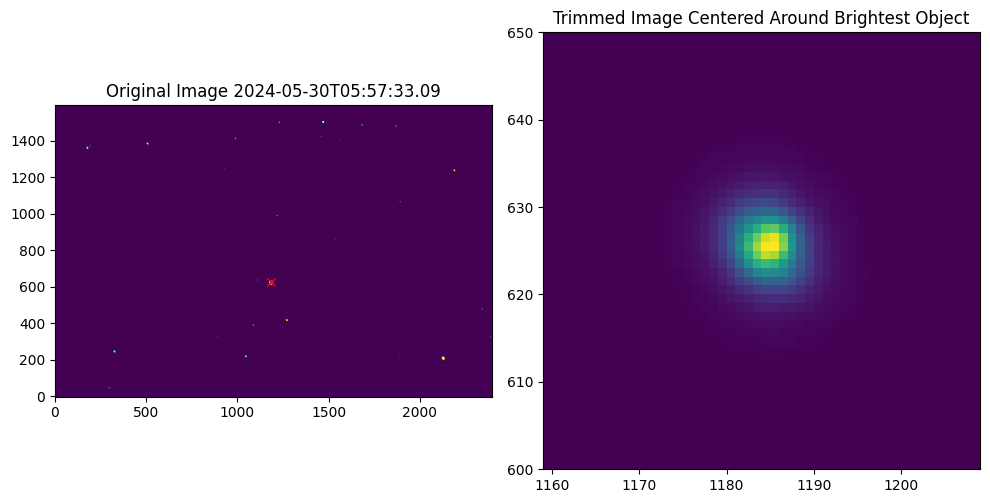

In [ ]:
# Assuming image_data contains your image data (e.g., from a FITS file)
data = calfits_R_data.astype(float)
bkg = sep.Background(data)
data_sub = data - bkg.back()  # Background subtracted data

# Perform source extraction with background subtracted data
sources = sep.extract(data_sub, bkg.globalrms)

brightest_source = None
brightest_flux = 0.0  # Assuming flux is a measure of brightness

# Iterate over detected sources to find the brightest one
for source in sources:
    flux = source['flux']  # Assuming 'flux' is the measure of brightness
    if flux > brightest_flux:
        brightest_flux = flux
        brightest_source = source

# Let's assume to select the first detected source
selected_source = brightest_source

region_size = 50  # Example size

# Extract the coordinates of the brightest source
x_centroid = brightest_source['x']
y_centroid = brightest_source['y']

# Calculate the ROI coordinates based on the trimmed image size
half_size = region_size // 2  # Half of the region size
x_min = int(max(x_centroid - half_size, 0))
x_max = int(min(x_centroid + half_size, data.shape[1]))
y_min = int(max(y_centroid - half_size, 0))
y_max = int(min(y_centroid + half_size, data.shape[0]))

# Ensure the ROI size is consistent
roi_width = x_max - x_min
roi_height = y_max - y_min
if roi_width != region_size or roi_height != region_size:
    # Adjust the ROI to maintain the specified size
    x_min = max(x_centroid - half_size, 0)
    x_max = min(x_centroid + half_size, data.shape[1])
    y_min = max(y_centroid - half_size, 0)
    y_max = min(y_centroid + half_size, data.shape[0])

# Trim the image to the ROI
trimmed_image = data[y_min:y_max, x_min:x_max]
trimmed_image_contiguous = np.ascontiguousarray(trimmed_image)

# Perform source extraction on the trimmed image
trimmed_sources = sep.extract(trimmed_image_contiguous, bkg.globalrms)

# Check if only one source is detected in the trimmed image
if len(trimmed_sources) == 1:
    print("The brightest source is the only one in the trimmed image.")
    x_source = brightest_source['x']
    y_source = brightest_source['y']
    print(f"Coordinates of the source: x = {x_source}, y = {y_source}")
else:
    print("There are multiple sources in the trimmed image.")

print("RA: ", ra)
print("DEC: ", dec)

# Plot the original and trimmed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(data, cmap='viridis', origin='lower', vmin=100, vmax=500)
plt.plot(x_centroid, y_centroid, 'rx')  # Mark the brightest source
plt.title('Original Image ' + observation_date)

plt.subplot(1, 2, 2)
plt.imshow(trimmed_image, cmap='viridis', origin='lower', extent=[x_min, x_max, y_min, y_max], )
plt.title('Trimmed Image Centered Around Brightest Object')

plt.tight_layout()
plt.show()


In [ ]:
# Define a 2D Gaussian function with an offset parameter
def gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
    c = (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
    g = amplitude * np.exp(-(a * (x - xo)**2 + 2 * b * (x - xo) * (y - yo) + c * (y - yo)**2)) + offset
    return g.ravel()

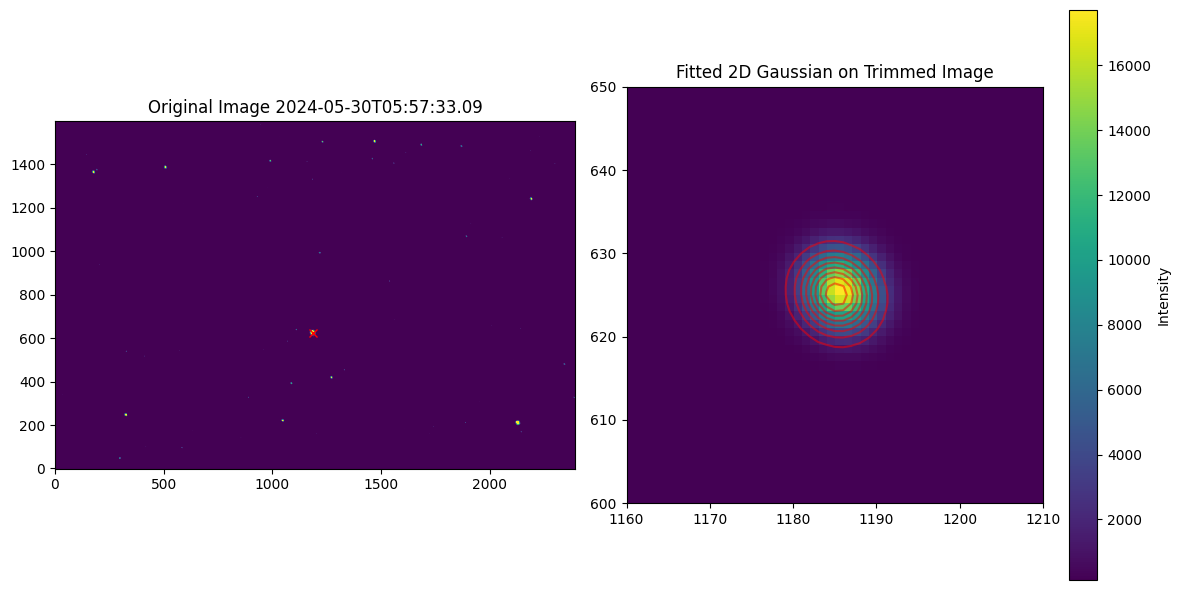

In [ ]:
data = calfits_R_data.astype(float)

# Define the ROI coordinates based on the image size
region_size = 50  # Example size
half_size = region_size // 2  # Half of the region size

# Find the brightest pixel coordinates in the full image
brightest_index_full = np.argmax(data)
y_centroid_full, x_centroid_full = np.unravel_index(brightest_index_full, data.shape)

# Calculate the ROI coordinates based on the brightest pixel in the full image
x_min_full = int(max(x_centroid_full - half_size, 0))
x_max_full = int(min(x_centroid_full + half_size, data.shape[1]))
y_min_full = int(max(y_centroid_full - half_size, 0))
y_max_full = int(min(y_centroid_full + half_size, data.shape[0]))

# Extract the ROI from the full image
trimmed_image_full = data[y_min_full:y_max_full, x_min_full:x_max_full]

y, x = np.mgrid[:trimmed_image_contiguous.shape[0], :trimmed_image_contiguous.shape[1]]
x_data = x.flatten()
y_data = y.flatten()
z_data = trimmed_image_contiguous.flatten()

# Fit the Gaussian function to the data
initial_guess = (np.max(z_data), region_size / 2, region_size / 2, 10, 10, 0, np.median(z_data))

# Fit the Gaussian function to the data
popt, pcov = curve_fit(gaussian, (x_data, y_data), z_data, p0=initial_guess)

predicted_values = gaussian((x_data, y_data), *popt)

# Calculate the residuals for x and y separately
residuals_x = x_data - predicted_values[0]
residuals_y = y_data - predicted_values[1]

# Generate the 2D Gaussian using the fitted parameters
gaussian_image = gaussian((x, y), *popt).reshape(trimmed_image_contiguous.shape)

# Plot the original image and the fitted Gaussian
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(data, cmap='viridis', origin='lower', vmin=100, vmax=500)
plt.plot(x_centroid_full, y_centroid_full, 'rx')  # Mark the brightest source in the full image
plt.title('Original Image ' + observation_date)

plt.subplot(1, 2, 2)
plt.imshow(gaussian_image, cmap='viridis', origin='lower', extent=[x_min_full, x_max_full, y_min_full, y_max_full])
plt.colorbar(label='Intensity')  # Add colorbar for intensity
plt.contour(x + x_min_full, y + y_min_full, gaussian_image, levels=10, colors='r', alpha=0.5)  # Add Gaussian contour
plt.title('Fitted 2D Gaussian on Trimmed Image')
plt.tight_layout()
plt.show()

# Print the fitted parameters
print('Best Fit Parameters Using Numpy curve_fit:')
print('Amplitude:', popt[0])
print('Center X:', popt[1] + x_min_full)  # Add ROI offset to get original coordinates
print('Center Y:', popt[2] + y_min_full)  # Add ROI offset to get original coordinates
print('Sigma X:', popt[3])
print('Sigma Y:', popt[4])
print('Theta:', popt[5])
print('Offset:', popt[6])

In [ ]:
def log_likelihood(params, x, y, data):
    amplitude, center_x, center_y, sigma_x, sigma_y, theta, offset = params
    model = gaussian((x, y), amplitude, center_x, center_y, sigma_x, sigma_y, theta, offset)
    return -0.5 * np.sum((data - model) ** 2)

def log_prior(params):
    amplitude, center_x, center_y, sigma_x, sigma_y, theta, offset = params
    if 0 < amplitude < 1e6 and 0 < sigma_x < 100 and 0 < sigma_y < 100:
        return 0.0
    return -np.inf

def log_probability(params, x, y, data):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, data)

Best Fit Parameters Using Numpy curve_fit:
Amplitude: 17630.457131895295
Center X: 1185.209279281275
Center Y: 625.096310986724
Sigma X: 3.06191042413005
Sigma Y: 2.788442027642592
Theta: -11.565154315601658
Offset: 134.43769044407523


100%|██████████| 5000/5000 [00:28<00:00, 177.48it/s]


Center X: 1185.2092763183284 ± 4.5094612170985994e-05
Center Y: 625.0963119600578 ± 4.656946904998138e-05


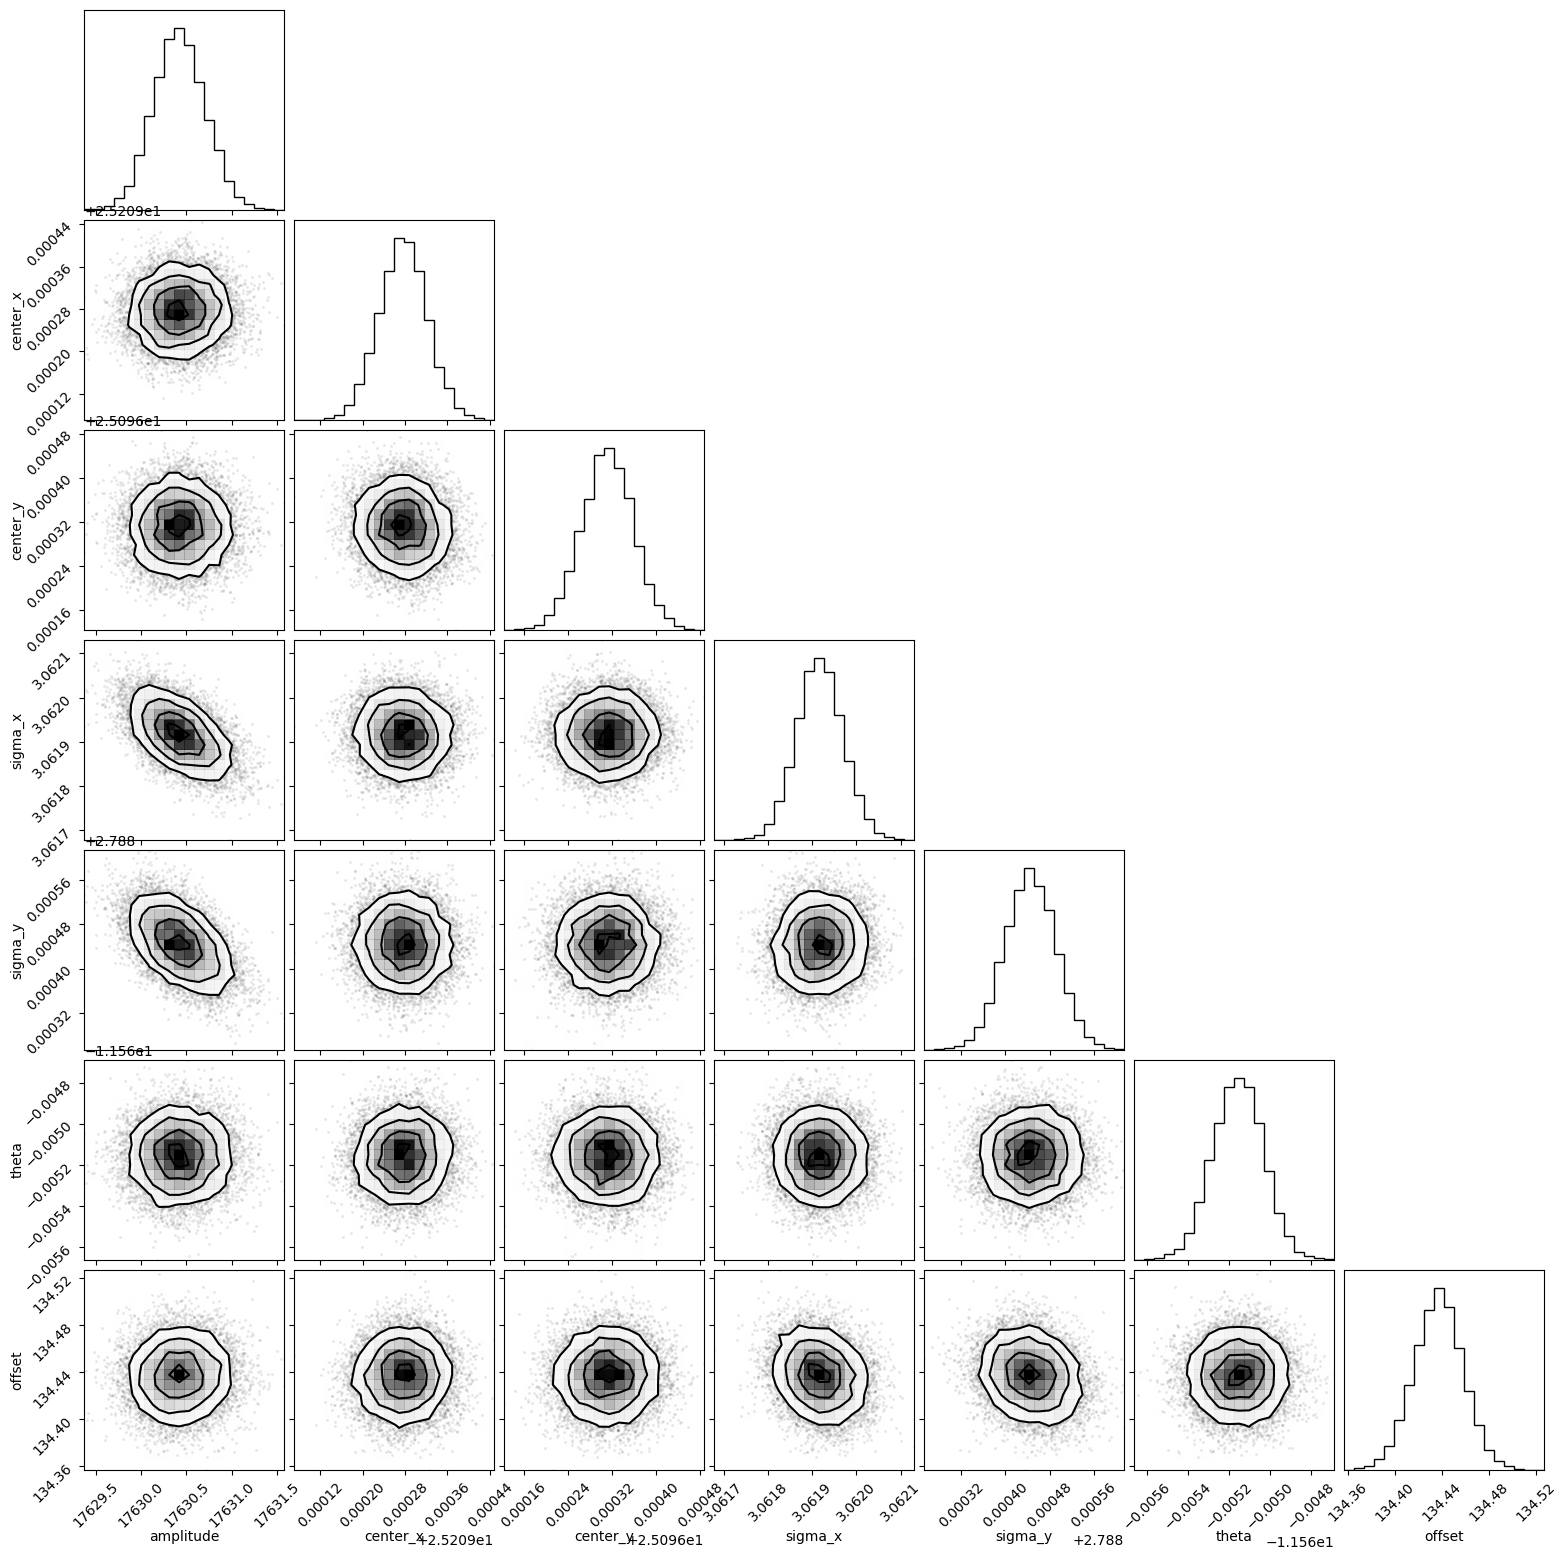

In [ ]:
# Trying monte carlo for funsies... doesnt use residual calculations so it could be impervious to the missing error calculations?
height, width = trimmed_image_contiguous.shape
y, x = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
x_flat = x.ravel()
y_flat = y.ravel()
data_flat = trimmed_image_contiguous.ravel()

assert x_flat.shape == y_flat.shape == data_flat.shape

# Initial guess
initial = np.array([popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6]]) # Use params from best fit curve_fit
nwalkers = 32
ndim = len(initial)

# Initialize the walkers around the initial guess
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x_flat, y_flat, data_flat))

# Run the MCMC
sampler.run_mcmc(pos, 5000, progress=True)

# Analyze the samples
samples = sampler.get_chain(discard=100, thin=15, flat=True)

# Plot the corner plot
fig = corner.corner(samples, labels=["amplitude", "center_x", "center_y", "sigma_x", "sigma_y", "theta", "offset"])

# Extract uncertainties
center_x_samples = samples[:, 1]
center_y_samples = samples[:, 2]
center_x_error = np.std(center_x_samples) # want to find the most common x and y out of these two arrays, at random choose a position and record the x and y
center_y_error = np.std(center_y_samples)

print(f"Center X: {np.mean(center_x_samples) + x_min_full} ± {center_x_error}")
print(f"Center Y: {np.mean(center_y_samples)+ y_min_full} ± {center_y_error}")


In [ ]:
# now we need to save center_x_samples and center_y_samples with each image
print(len(center_x_samples))

10432


In [ ]:
# want to use these two arrays and sample from it each time one x and its corresponding y as the center of pallas that we use with the orbital determination
# and run the orbital determination with each of the x and y samplings on all four? images to get those parameters
#run a corner plot on the output of the orbital determination
#np.random from the x and y arrays
#want to do this same process on the orbital determination

In [ ]:
# Assuming wcs is your WCS object and x_min_full, y_min_full are your offsets
center_x_samples_offset = samples[:, 1] + x_min_full
center_y_samples = samples[:, 2] + y_min_full

# Combine the adjusted x and y samples into a single array
combined_samples = np.vstack((center_x_samples + x_min_full, center_y_samples + y_min_full)).T

wcs = WCS(calfits_R[0].header)

# Convert pixel coordinates to RA and Dec
ra_dec_samples = wcs.all_pix2world(combined_samples, 1)

# Split the RA and Dec values into separate arrays
ra_samples = ra_dec_samples[:, 0]
dec_samples = ra_dec_samples[:, 1]

RA_DEC_Pairs = np.array(list(zip(ra_samples, dec_samples)))

In [ ]:
print(len(RA_DEC_Pairs))
print(RA_DEC_Pairs)

10432
[[244.44234485  26.66726028]
 [244.44234481  26.66726031]
 [244.44234482  26.66726029]
 ...
 [244.44234483  26.66726028]
 [244.4423448   26.66726029]
 [244.44234483  26.66726029]]


In [ ]:
print(f"Center X: {np.mean(center_x_samples) + x_min_full} ± {center_x_error}")
print(f"Center Y: {np.mean(center_y_samples)+ y_min_full} ± {center_y_error}")

Center X: 1185.2092763183284 ± 4.5094612170985994e-05
Center Y: 1225.0963119600578 ± 4.656946904998138e-05


In [ ]:
fr_x = np.mean(center_x_samples) + x_min_full
fr_y = np.mean(center_y_samples) + y_min_full

In [ ]:
ra, dec = wcs.all_pix2world([[fr_x, fr_y]], 0)[0]

# Calculate the Jacobian matrix
jacobian = wcs.pixel_scale_matrix

# Calculate the variances in pixel coordinates
covar_pix = np.array([[center_x_error**2, 0],
                      [0, center_y_error**2]])

# Convert pixel variances to world coordinate variances
covar_world = jacobian @ covar_pix @ jacobian.T

# Extract RA and Dec errors from the covariance matrix
ra_error = np.sqrt(covar_world[0, 0])
dec_error = np.sqrt(covar_world[1, 1])

In [ ]:
print(f"Center X: {np.mean(center_x_samples) + x_min_full} ± {center_x_error}")
print(f"Center Y: {np.mean(center_y_samples)+ y_min_full} ± {center_y_error}")
# Compare this to est ra and dec on ASTAP?

Center X: 1185.2092763183284 ± 4.5094612170985994e-05
Center Y: 1225.0963119600578 ± 4.656946904998138e-05


In [ ]:
print(f"Center RA: {ra} ± {ra_error}")
print(f"Center DEC: {dec}  ± {dec_error}")

Center RA: 244.44206245772568 ± 8.745738740315975e-09
Center DEC: 26.667348031182886  ± 8.574256881430246e-09


In [ ]:
print("YIPPEEEEEEE!!!!!!")

YIPPEEEEEEE!!!!!!


Burn-in period ends at: 1043 iterations


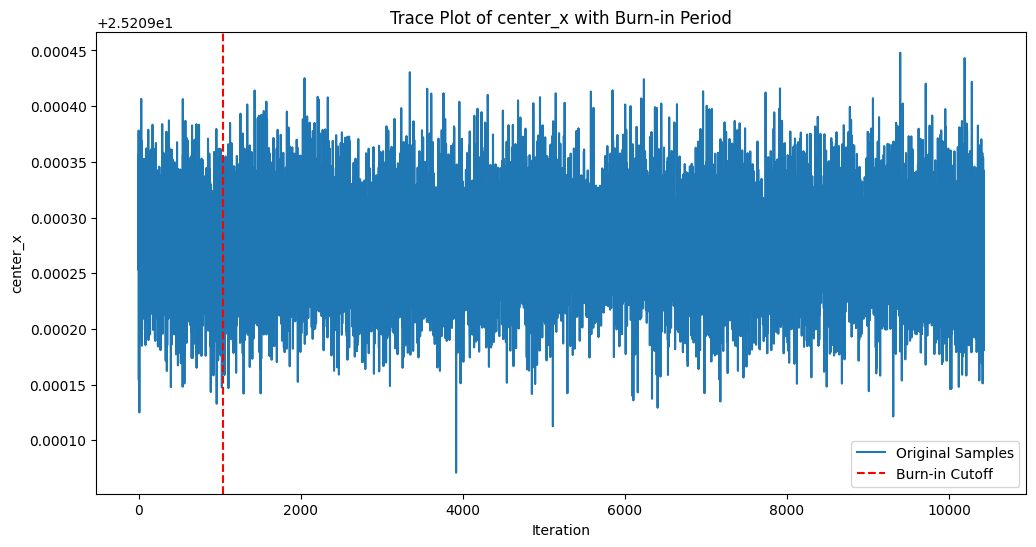

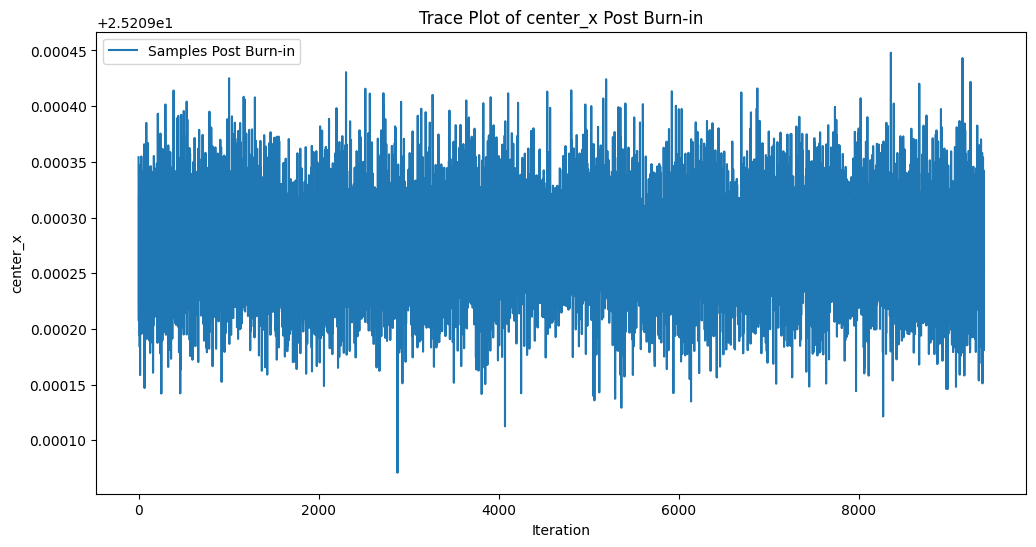

Number of samples after burn-in: 9389


In [ ]:
def geweke(z, first=0.1, last=0.5):
    if len(z.shape) != 1:
        raise ValueError('geweke diagnostic only defined for 1d arrays')
    if first + last >= 1:
        raise ValueError('invalid intervals for geweke diagnostic')
    z = np.asarray(z)
    n = len(z)
    b = int(first * n)
    e = int(last * n)
    x0 = z[:b]
    x1 = z[-e:]
    z0 = (x0.mean() - x1.mean()) / np.sqrt(x0.var() / len(x0) + x1.var() / len(x1))
    return z0

def find_burn_in(samples, first=0.1, last=0.5, confidence_interval=1.96):
    geweke_scores = []
    burn_in_index = 0
    n_samples = len(samples)

    for i in range(int(first * n_samples), n_samples):
        try:
            score = geweke(samples[:i], first=first, last=last)
            geweke_scores.append(score)
            if np.abs(score) < confidence_interval:
                burn_in_index = i
                break
        except:
            continue

    return burn_in_index

def remove_burn_in(samples, burn_in_period):
    return samples[burn_in_period:]

burn_in_period = find_burn_in(center_x_samples)
print(f"Burn-in period ends at: {burn_in_period} iterations")

# Remove burn-in samples
center_x_samples_post_burn_in = remove_burn_in(center_x_samples, burn_in_period)

plt.figure(figsize=(12, 6))
plt.plot(center_x_samples, label='Original Samples')
plt.axvline(burn_in_period, color='r', linestyle='--', label='Burn-in Cutoff')
plt.xlabel('Iteration')
plt.ylabel('center_x')
plt.title('Trace Plot of center_x with Burn-in Period')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(center_x_samples_post_burn_in, label='Samples Post Burn-in')
plt.xlabel('Iteration')
plt.ylabel('center_x')
plt.title('Trace Plot of center_x Post Burn-in')
plt.legend()
plt.show()

print(f"Number of samples after burn-in: {len(center_x_samples_post_burn_in)}")


Burn-in period ends at: 1043 iterations


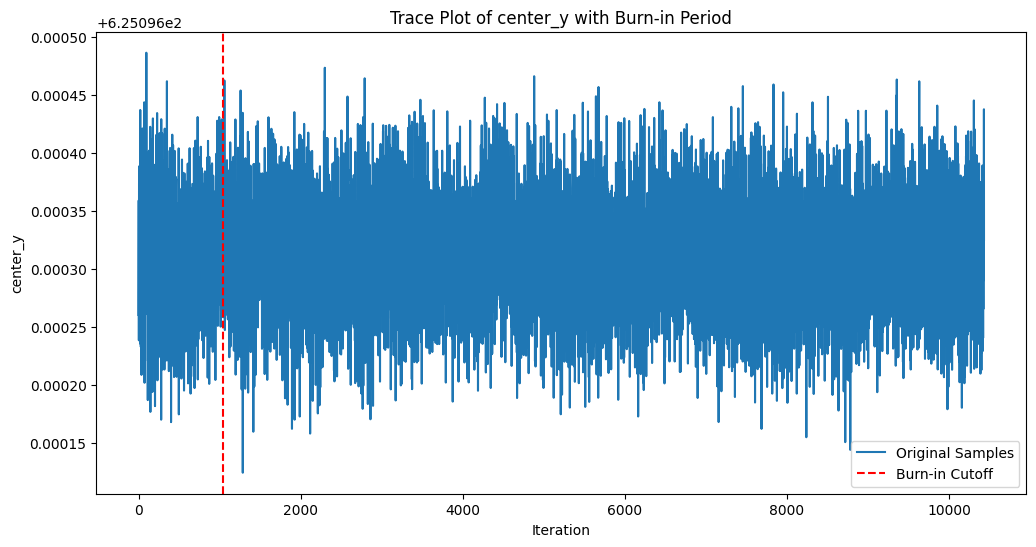

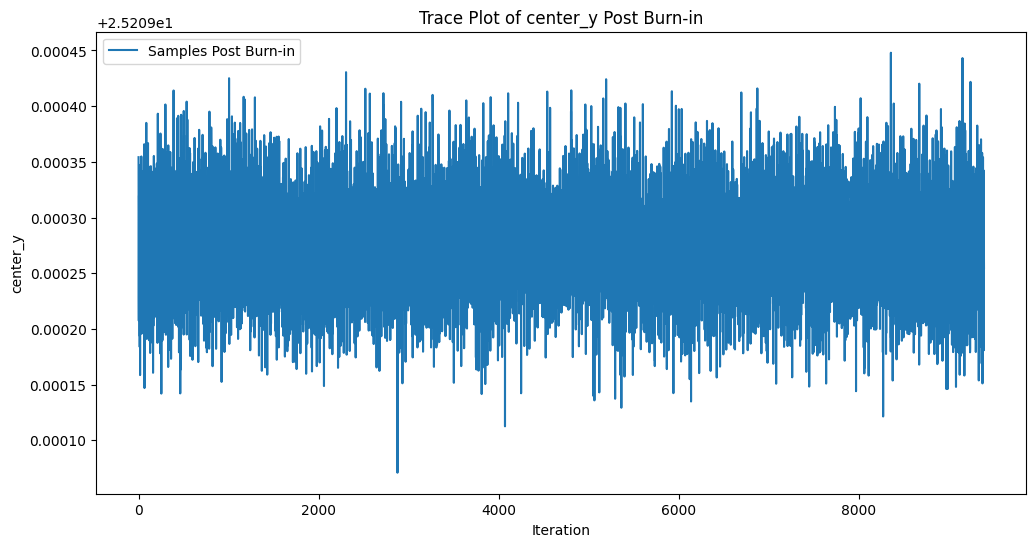

Number of samples after burn-in: 9389


In [ ]:
burn_in_period = find_burn_in(center_y_samples)
print(f"Burn-in period ends at: {burn_in_period} iterations")

# Remove burn-in samples
center_y_samples_post_burn_in = remove_burn_in(center_y_samples, burn_in_period)

plt.figure(figsize=(12, 6))
plt.plot(center_y_samples, label='Original Samples')
plt.axvline(burn_in_period, color='r', linestyle='--', label='Burn-in Cutoff')
plt.xlabel('Iteration')
plt.ylabel('center_y')
plt.title('Trace Plot of center_y with Burn-in Period')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(center_x_samples_post_burn_in, label='Samples Post Burn-in')
plt.xlabel('Iteration')
plt.ylabel('center_y')
plt.title('Trace Plot of center_y Post Burn-in')
plt.legend()
plt.show()

print(f"Number of samples after burn-in: {len(center_y_samples_post_burn_in)}")
